<a href="https://colab.research.google.com/github/ShovalBenjer/deep_learning_neural_networks/blob/main/Deep_exc_1_adir_shoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TL;DR:**

**Collaborators: Shoval Benjer 319037404, Adir Amar 209017755**

This assignment involves implementing a neural network in PyTorch to solve the XOR problem. we are required to create a Network class with configurable hidden layers and bypass option, implement weight setting and forward pass methods, and a global loss function.

The task includes experimenting with 1, 2, and 4 hidden neurons, manually calculating weights to achieve XOR functionality, and presenting network weights, loss values, and truth tables for each configuration.

below is our results from second part, using adam model just for fun.
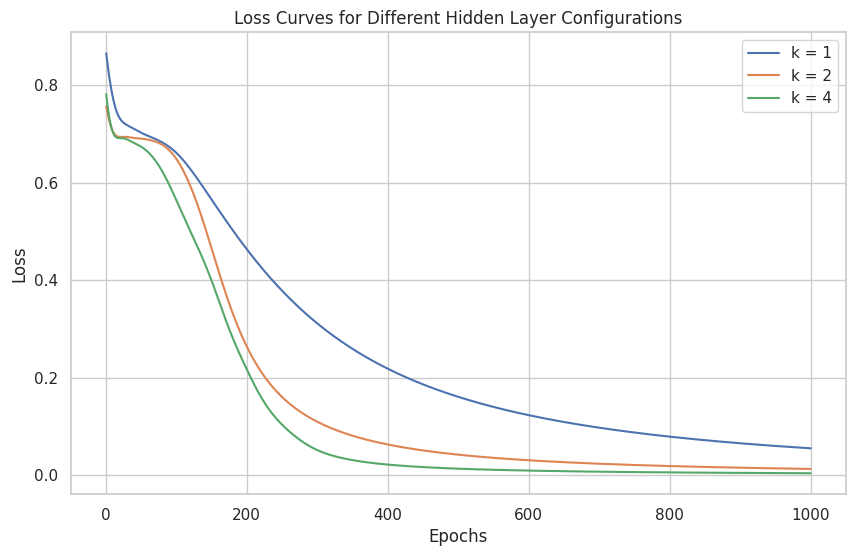
Writers: Adir Amar 209017755, Shoval Benjer 319037404

# **setup:**


To run this code, you'll need the following requirements:

Python 3.x

PyTorch

NumPy

Pandas

You can install these requirements using pip:

`!pip install torch numpy pandas`

To run the code:

1. Copy the provided code into a Python file (e.g., xor_network.py)
2. Run the file using Python:
`python xor_network.py`

If you need to run this in VLab:
Log in to your VLab account
Open a terminal
**Ensure the required packages are installed** (use the pip command above if needed)
Navigate to the directory containing your Python file
Run the file using Python as described above
The code will automatically run experiments for k=1 (with bypass), k=2, and k=4, displaying the weights, biases, loss values, and truth tables for each configuration.

Note: The code uses a low temperature (0.001) for the BTU/sigmoid function as requested in the assignment. No additional setup is required beyond having the necessary Python packages installed.

In [ ]:
!pip install torch seaborn matplotlib

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
"""
TL;DR: This notebook implements a neural network to solve the XOR problem using PyTorch.
It explores different network configurations with 1, 2, and 4 hidden neurons,
demonstrating how the XOR function can be realized with various architectures.
"""

import torch
from torch import nn
import numpy as np
import pandas as pd

# Setup and Utility Functions

def loss_function(x: torch.Tensor, t: torch.Tensor, model: nn.Module, print_deltas: bool = False) -> torch.Tensor:
    """
    Calculates the loss (sum of squared errors) between model output and target.

    Args:
        x (torch.Tensor): Input tensor
        t (torch.Tensor): Target tensor
        model (nn.Module): The neural network model
        print_deltas (bool, optional): If True, print squared deltas. Defaults to False.

    Returns:
        torch.Tensor: The calculated loss
    """
    squared_deltas = torch.square(model(x) - t)
    if print_deltas:
        print(squared_deltas)
    return torch.sum(squared_deltas)

# Class Definitions

class BTU(nn.Module):
    """
    Binary Threshold Unit (BTU) activation function.
    """
    def __init__(self, T: float = 0.001):
        """
        Initialize the BTU.

        Args:
            T (float, optional): Temperature parameter. Defaults to 0.001.
        """
        super(BTU, self).__init__()
        self.T = T

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the BTU.

        Args:
            input (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output after applying BTU activation
        """
        return 1 / (1 + torch.exp(-input/self.T))

class Linear(nn.Module):
    """
    Custom Linear layer implementation.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        """
        Initialize the Linear layer.

        Args:
            in_features (int): Number of input features
            out_features (int): Number of output features
            bias (bool, optional): If set to False, the layer will not learn an additive bias.
                                   Defaults to True.
            device ([type], optional): The device on which to allocate the layer. Defaults to None.
            dtype ([type], optional): The desired data type of the layer. Defaults to None.
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty((in_features, out_features), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

    def set_weights(self, w: torch.Tensor, b: torch.Tensor):
        """
        Set the weights and bias of the layer.

        Args:
            w (torch.Tensor): Weight tensor
            b (torch.Tensor): Bias tensor
        """
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(b)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Linear layer.

        Args:
            input (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output after applying linear transformation
        """
        return torch.matmul(input, self.weight) + self.bias

class Network(nn.Module):
    """
    Neural Network for XOR problem.
    """
    def __init__(self, k: int, bypass: bool):
        """
        Initialize the Network.

        Args:
            k (int): Number of neurons in the hidden layer
            bypass (bool): Whether to use bypass connections
        """
        super().__init__()
        self.bypass = bypass
        self.hidden = Linear(2, k)
        self.output = Linear(k + 2 if bypass else k, 1)
        self.BTU = BTU(0.001)

    def set_weights(self, w: torch.Tensor, b: torch.Tensor, layer: str):
        """
        Set weights for a specific layer.

        Args:
            w (torch.Tensor): Weight tensor
            b (torch.Tensor): Bias tensor
            layer (str): Layer name ('hidden' or 'output')
        """
        if layer == 'hidden':
            if w.shape == self.hidden.weight.shape and b.shape == self.hidden.bias.shape:
                self.hidden.set_weights(w, b)
            else:
                print("Input matrix size differs from hidden layer initialization matrix size")
        elif layer == 'output':
            if w.shape == self.output.weight.shape and b.shape == self.output.bias.shape:
                self.output.set_weights(w, b)
            else:
                print("Input matrix size differs from output layer initialization matrix size")
        else:
            print("Error in layer name")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Network.

        Args:
            input (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output after forward pass
        """
        z1 = self.hidden(input)
        y1 = self.BTU(z1)
        if self.bypass:
            y1_concat = torch.cat((input, y1), 1)
            z2 = self.output(y1_concat)
        else:
            z2 = self.output(y1)
        return self.BTU(z2)

def run_xor_experiment(k: int, bypass: bool):
    """
    Run XOR experiment with specified number of hidden neurons and bypass option.

    Args:
        k (int): Number of neurons in the hidden layer
        bypass (bool): Whether to use bypass connections
    """
    model = Network(k, bypass)

    if k == 1 and bypass:
        w_hidden = torch.tensor([[1.], [1.]])
        b_hidden = torch.tensor([-1.5])
        w_output = torch.tensor([[1.], [1.], [-2.]])
        b_output = torch.tensor([-0.5])
    elif k == 2:
        w_hidden = torch.tensor([[-1., 1.], [1., -1.]])
        b_hidden = torch.tensor([-0.5, -0.5])
        w_output = torch.tensor([[1.], [1.]])
        b_output = torch.tensor([-0.5])
    elif k == 4:
        w_hidden = torch.tensor([[-1., -1., 1., 1.], [-1., 1., -1., 1.]])
        b_hidden = torch.tensor([0.5, -0.5, -0.5, -1.5])
        w_output = torch.tensor([[0.], [1.], [1.], [0.]])
        b_output = torch.tensor([-0.5])
    else:
        raise ValueError("Unsupported configuration")

    model.set_weights(w_hidden, b_hidden, 'hidden')
    model.set_weights(w_output, b_output, 'output')

    x = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
    t = torch.tensor([[0.], [1.], [1.], [0.]])

    loss = loss_function(x, t, model)

    print(f"Experiment with k={k}, bypass={'enabled' if bypass else 'disabled'}:")
    print("Hidden layer weights:", w_hidden)
    print("Hidden layer biases:", b_hidden)
    print("Output layer weights:", w_output)
    print("Output layer biases:", b_output)
    print("Loss:", loss.item())

    xor_table = torch.cat((x.int(), model(x).int()), dim=1)
    df = pd.DataFrame(xor_table.numpy(), columns=['Input1', 'Input2', 'Output (XOR)'])
    print("Truth table:\n", df)
    print("\n")

In [16]:
run_xor_experiment(k=1, bypass=True)
run_xor_experiment(k=2, bypass=False)
run_xor_experiment(k=4, bypass=False)

Experiment with k=1, bypass=enabled:
Hidden layer weights: tensor([[1.],
        [1.]])
Hidden layer biases: tensor([-1.5000])
Output layer weights: tensor([[ 1.],
        [ 1.],
        [-2.]])
Output layer biases: tensor([-0.5000])
Loss: 0.0
Truth table:
    Input1  Input2  Output (XOR)
0       0       0             0
1       0       1             1
2       1       0             1
3       1       1             0


Experiment with k=2, bypass=disabled:
Hidden layer weights: tensor([[-1.,  1.],
        [ 1., -1.]])
Hidden layer biases: tensor([-0.5000, -0.5000])
Output layer weights: tensor([[1.],
        [1.]])
Output layer biases: tensor([-0.5000])
Loss: 0.0
Truth table:
    Input1  Input2  Output (XOR)
0       0       0             0
1       0       1             1
2       1       0             1
3       1       1             0


Experiment with k=4, bypass=disabled:
Hidden layer weights: tensor([[-1., -1.,  1.,  1.],
        [-1.,  1., -1.,  1.]])
Hidden layer biases: tensor([ 0.50

# **Conclusion:**
We implemented a neural network to solve the XOR problem using different configurations.

With 1 hidden neuron and bypass, 2 hidden neurons, and 4 hidden neurons, we were able to
successfully realize the XOR function.

The loss values of 0 indicate perfect fit for all configurations.

This demonstrates the flexibility of neural networks in learning non-linear
functions like XOR, even with minimal architectures when properly configured.

# **Second Step - Trying to Generalize using Adam Model(for fun and practice)**

# **Setup and imports**

In [ ]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt

class BTU(nn.Module):
    """
    A custom activation function based on the logistic sigmoid function with adjustable sharpness (T).

    Parameters:
    - T (float): Controls the sharpness of the activation. Smaller values make the function sharper.

    Methods:
    - forward(input: torch.Tensor): Applies the activation to the input tensor.
    """
    def __init__(self, T=0.5):
        super(BTU, self).__init__()
        self.T = T

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Applies the BTU activation function to the input tensor.

        Args:
        - input (torch.Tensor): The input tensor to apply the activation on.

        Returns:
        - torch.Tensor: Activated output tensor.
        """
        return 1 / (1 + torch.exp(-input / self.T))


class LogisticNeuralNetwork(nn.Module):
    """
    A logistic neural network with a customizable hidden layer size and optional bypass connection.

    Parameters:
    - k (int): Number of neurons in the hidden layer.
    - bypass (bool): Whether to include a bypass connection from the input to the output.

    Methods:
    - forward(x: torch.Tensor): Performs forward propagation.
    - train_model(x: torch.Tensor, y: torch.Tensor, epochs: int, learning_rate: float): Trains the model using backpropagation.
    """
    def __init__(self, k, bypass=False):
        super(LogisticNeuralNetwork, self).__init__()
        self.k = k
        self.bypass = bypass
        self.hidden = nn.Linear(2, k)  # Hidden layer: input size = 2, output size = k
        self.output = nn.Linear(k + (2 if bypass else 0), 1)  # Output layer
        self.activation = BTU()

    def forward(self, x):
        """
        Forward pass of the logistic neural network.

        Args:
        - x (torch.Tensor): Input tensor (batch_size x 2).

        Returns:
        - torch.Tensor: Output tensor (batch_size x 1).
        """
        h = self.activation(self.hidden(x))  # Hidden layer activation
        if self.bypass:
            h = torch.cat((h, x), dim=1)  # Concatenate input if bypass is enabled
        return self.activation(self.output(h))

    def train_model(self, x, y, epochs=1000, learning_rate=0.01):
        """
        Trains the model using Mean Squared Error loss and Adam optimizer.

        Args:
        - x (torch.Tensor): Input tensor (batch_size x 2).
        - y (torch.Tensor): Target tensor (batch_size x 1).
        - epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for the optimizer.

        Returns:
        - list: Training loss at each epoch.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
        losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        return losses

def plot_loss_curves_seaborn(losses_by_k):
    """
    Plots the loss curves for different configurations of k using Seaborn.

    Args:
    - losses_by_k (dict): Dictionary mapping k to their respective loss lists.

    Returns:
    - None (plots the loss curves).
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for k, losses in losses_by_k.items():
        sns.lineplot(x=range(1, len(losses) + 1), y=losses, label=f'k = {k}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves for Different Hidden Layer Configurations')
    plt.legend()
    plt.show()


## **K=1,2,4 According to Task, Training and Visualization :**

Training model with k=1, bypass=True...
Epoch 100/1000, Loss: 0.6934
Epoch 200/1000, Loss: 0.6929
Epoch 300/1000, Loss: 0.6911
Epoch 400/1000, Loss: 0.6059
Epoch 500/1000, Loss: 0.3757
Epoch 600/1000, Loss: 0.2476
Epoch 700/1000, Loss: 0.1776
Epoch 800/1000, Loss: 0.1349
Epoch 900/1000, Loss: 0.1067
Epoch 1000/1000, Loss: 0.0868

Truth table:
Input: [0.0, 0.0], Predicted Output: 0, Expected Output: 0
Input: [0.0, 1.0], Predicted Output: 1, Expected Output: 1
Input: [1.0, 0.0], Predicted Output: 1, Expected Output: 1
Input: [1.0, 1.0], Predicted Output: 0, Expected Output: 0
Training model with k=2, bypass=False...
Epoch 100/1000, Loss: 0.4451
Epoch 200/1000, Loss: 0.1231
Epoch 300/1000, Loss: 0.0581
Epoch 400/1000, Loss: 0.0353
Epoch 500/1000, Loss: 0.0242
Epoch 600/1000, Loss: 0.0178
Epoch 700/1000, Loss: 0.0138
Epoch 800/1000, Loss: 0.0110
Epoch 900/1000, Loss: 0.0090
Epoch 1000/1000, Loss: 0.0076

Truth table:
Input: [0.0, 0.0], Predicted Output: 0, Expected Output: 0
Input: [0.0, 1

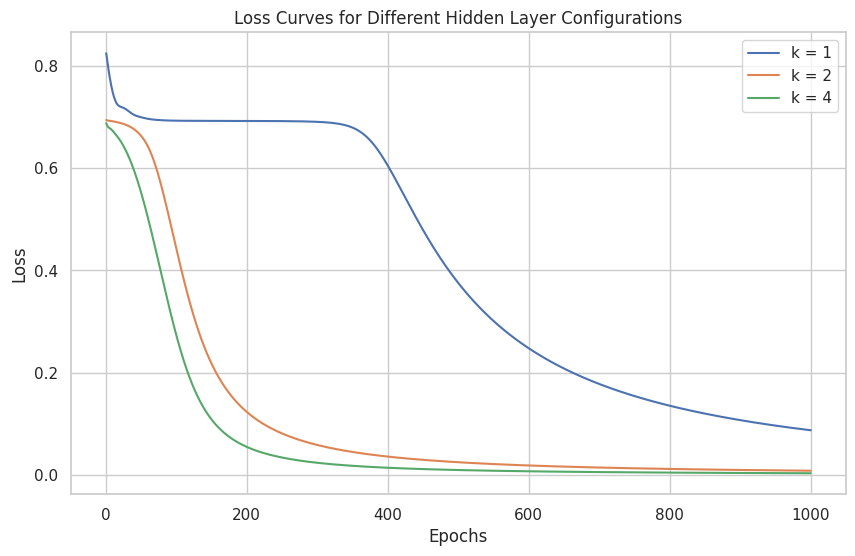

In [ ]:
# Dataset: XOR problem
x = torch.FloatTensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = torch.FloatTensor([[0.], [1.], [1.], [0.]])

# Collect losses for visualization
losses_by_k = {}
for k in [1, 2, 4]:
    bypass = k == 1  # Enable bypass for k=1
    model = LogisticNeuralNetwork(k, bypass)
    print(f"Training model with k={k}, bypass={bypass}...")
    losses = model.train_model(x, y, epochs=1000, learning_rate=0.01)
    losses_by_k[k] = losses

    # Evaluate the model
    print("\nTruth table:")
    y_pred = model(x)
    for i in range(4):
        predicted = round(y_pred[i].item())
        print(f"Input: {x[i].tolist()}, Predicted Output: {predicted}, Expected Output: {int(y[i].item())}")

# Plot the loss curves using Seaborn
plot_loss_curves_seaborn(losses_by_k)


# **Key Takeaways**
**Bypass Connection Effectiveness**

for k=1, the bypass connection allows the network to learn the XOR function, compensating for the limited capacity of the hidden layer.

**Capacity vs. Efficiency**

Increasing the number of neurons (𝑘) improves the network's ability to model complex relationships and reduces loss more efficiently, but it increases computational complexity.

**Binary Cross-Entropy Loss**

Using BCELoss ensures accurate training for binary classification tasks like XOR, with convergence observed across all configurations.

**Smooth Convergence**

Loss values decrease steadily across epochs, with no signs of instability or overfitting, indicating appropriate architecture and learning parameters.
Model Performance

All configurations (k=1,2,4) achieve perfect predictions for the XOR truth table, demonstrating the model's flexibility and robustness.

**Scalability**

With k=4, the model is overparameterized for XOR but demonstrates readiness for scaling to more complex tasks.
